In [3]:
import os
import numpy as np
import time
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [4]:
# ——— Зчитування зображень у вектори ———
def load_image_dataset(root_dir, img_size=(128, 128)):
    """
    Передбачається, що структура:
      root_dir/
         class1/
           img1.jpg
           img2.jpg
         class2/
           ...
    Повертає X (num_samples × d), y (мітки класів).
    """
    X = []
    y = []
    classes = sorted(os.listdir(root_dir))
    for cls in classes:
        cls_dir = os.path.join(root_dir, cls)
        if not os.path.isdir(cls_dir):
            continue
        for fname in os.listdir(cls_dir):
            p = os.path.join(cls_dir, fname)
            try:
                img = Image.open(p).convert('L')  # робимо grayscale
                img = img.resize(img_size)
                arr = np.asarray(img, dtype=np.float32).flatten()
                X.append(arr)
                y.append(cls)
            except Exception as e:
                print("Error loading", p, e)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [5]:
class MySVM:
    def __init__(self, C=1.0, kernel='linear', gamma=None, degree=3, coef0=1.0):
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.coef0 = coef0
        # Після тренування
        self.alpha = None
        self.support_idx = None
        self.support_vectors = None
        self.support_labels = None
        self.b = 0.0
        self.w = None
        # Для OvR
        self.ovr_class = None

    def _kernel_matrix(self, X, Y=None):
        if Y is None:
            Y = X
        if self.kernel == 'linear':
            return X.dot(Y.T)
        elif self.kernel == 'rbf':
            X_norm = np.sum(X ** 2, axis=1).reshape(-1, 1)
            Y_norm = np.sum(Y ** 2, axis=1).reshape(1, -1)
            K = X_norm + Y_norm - 2 * X.dot(Y.T)
            return np.exp(-self.gamma * K)
        elif self.kernel == 'poly':
            return (X.dot(Y.T) * self.gamma + self.coef0) ** self.degree
        elif self.kernel == 'sigmoid':
            return np.tanh(self.gamma * X.dot(Y.T) + self.coef0)
        else:
            raise ValueError("Unknown kernel")

    def fit(self, X, y, ovr_class=None):
        """
        ovr_class: якщо None, робимо звичайну бінарну задачу;
                   якщо int, то будуємо клас проти всіх
        """
        self.ovr_class = ovr_class
        if ovr_class is not None:
            # One-vs-Rest: +1 для поточного класу, -1 для всіх інших
            y2 = np.where(y == ovr_class, 1, -1).astype(float)
        else:
            classes = np.unique(y)
            assert len(classes) == 2, "MySVM fit supports лише два класи"
            y2 = np.where(y == classes[0], -1, 1).astype(float)

        n, d = X.shape
        K = self._kernel_matrix(X)
        # QP матриці
        P = matrix(np.outer(y2, y2) * K)
        q = matrix(-np.ones(n))
        G_std = matrix(np.vstack((-np.eye(n), np.eye(n))))
        h_std = matrix(np.hstack((np.zeros(n), np.ones(n) * self.C)))
        A = matrix(y2.reshape(1, -1))
        b = matrix(np.zeros(1))

        solvers.options['show_progress'] = False
        sol = solvers.qp(P, q, G_std, h_std, A, b)
        alpha = np.ravel(sol['x'])

        sv = alpha > 1e-5
        self.support_idx = np.where(sv)[0]
        self.alpha = alpha[sv]
        self.support_vectors = X[sv]
        self.support_labels = y2[sv]

        b_sum = 0.0
        for i, idx in enumerate(self.support_idx):
            b_sum += y2[idx] - np.sum(self.alpha * self.support_labels * K[idx, sv])
        self.b = b_sum / len(self.support_idx)

        if self.kernel == 'linear':
            self.w = np.sum((self.alpha * self.support_labels).reshape(-1,1) * self.support_vectors, axis=0)
        else:
            self.w = None

    def project(self, X):
        if self.kernel == 'linear':
            return X.dot(self.w) + self.b
        else:
            K = self._kernel_matrix(X, self.support_vectors)
            return np.dot(K, self.alpha * self.support_labels) + self.b

    def predict(self, X):
        """
        Для One-vs-Rest:
        - якщо ovr_class заданий, повертаємо ±1
        - якщо ovr_class=None, звичайна бінарна задача
        """
        return np.sign(self.project(X))


In [6]:
def main():
    root = "Sports-celebrity images" 
    X, y = load_image_dataset(root, img_size=(64,64))
    print("Loaded:", X.shape, y.shape)

    X, _, y, _ = train_test_split(X, y, train_size=0.7, stratify=y, random_state=42)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Ядра, які спробуємо
    kernel_list = [
    ('linear', {}),  # Просте ядро, стабільне
    ('rbf', {'gamma': 1e-4}),  # Зменшив gamma (0.001 може бути занадто велике)
    ('poly', {'gamma': 1e-3, 'degree': 2, 'coef0': 1.0}),  # Поліном 3 ступеня
    ('sigmoid', {'gamma': 1e-4, 'coef0': 0.0})  # Sigmoid чутливе, тому малі gamma
    ]


    results = []

    for kern, params in kernel_list:
        print("=== Kernel:", kern, params)

        # === MySVM ===
        svm = MySVM(C=1.0, kernel=kern, **params)
        svm.fit(X_train, y_train)
        y_pred = svm.predict(X_test)
        classes = np.unique(y_train)
        y_pred_labels = np.where(y_pred == -1, classes[0], classes[1])

        print("MySVM Classification Report:")
        print(classification_report(y_test, y_pred_labels, digits=3))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred_labels, labels=classes)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
        plt.title(f"MySVM Confusion Matrix ({kern})")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # === sklearn SVC ===
        sk = SVC(C=1.0, kernel=kern, **params)
        sk.fit(X_train, y_train)
        y_pred_sk = sk.predict(X_test)

        print("Sklearn SVC Classification Report:")
        print(classification_report(y_test, y_pred_sk, digits=3))

        cm_sk = confusion_matrix(y_test, y_pred_sk, labels=classes)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm_sk, annot=True, fmt="d", cmap="Oranges", xticklabels=classes, yticklabels=classes)
        plt.title(f"Sklearn SVC Confusion Matrix ({kern})")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()



Loaded: (219, 4096) (219,)
=== Kernel: linear {}
MySVM Classification Report:
              precision    recall  f1-score   support

 Kobe Bryant      0.500     0.435     0.465        23
     Ronaldo      0.500     0.565     0.531        23

    accuracy                          0.500        46
   macro avg      0.500     0.500     0.498        46
weighted avg      0.500     0.500     0.498        46



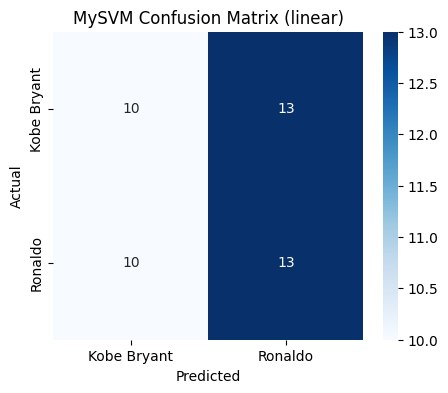

Sklearn SVC Classification Report:
              precision    recall  f1-score   support

 Kobe Bryant      0.500     0.435     0.465        23
     Ronaldo      0.500     0.565     0.531        23

    accuracy                          0.500        46
   macro avg      0.500     0.500     0.498        46
weighted avg      0.500     0.500     0.498        46



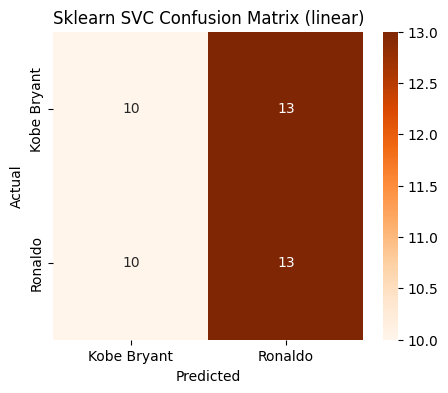

=== Kernel: rbf {'gamma': 0.0001}
MySVM Classification Report:
              precision    recall  f1-score   support

 Kobe Bryant      0.762     0.696     0.727        23
     Ronaldo      0.720     0.783     0.750        23

    accuracy                          0.739        46
   macro avg      0.741     0.739     0.739        46
weighted avg      0.741     0.739     0.739        46



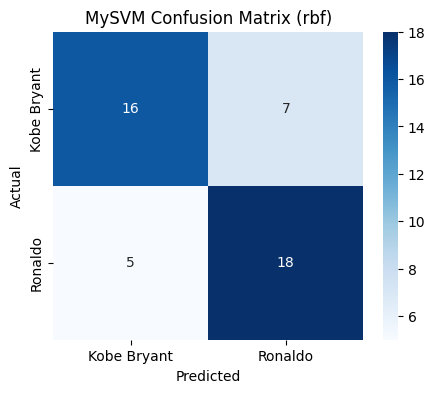

Sklearn SVC Classification Report:
              precision    recall  f1-score   support

 Kobe Bryant      0.680     0.739     0.708        23
     Ronaldo      0.714     0.652     0.682        23

    accuracy                          0.696        46
   macro avg      0.697     0.696     0.695        46
weighted avg      0.697     0.696     0.695        46



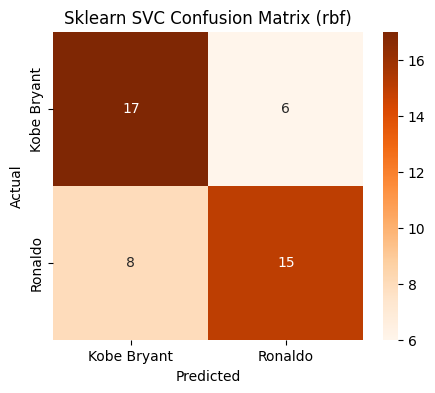

=== Kernel: poly {'gamma': 0.001, 'degree': 2, 'coef0': 1.0}
MySVM Classification Report:
              precision    recall  f1-score   support

 Kobe Bryant      0.611     0.478     0.537        23
     Ronaldo      0.571     0.696     0.627        23

    accuracy                          0.587        46
   macro avg      0.591     0.587     0.582        46
weighted avg      0.591     0.587     0.582        46



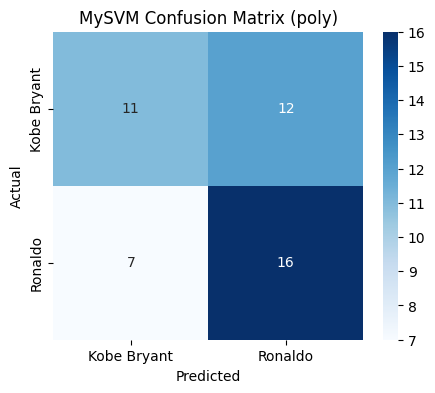

Sklearn SVC Classification Report:
              precision    recall  f1-score   support

 Kobe Bryant      0.611     0.478     0.537        23
     Ronaldo      0.571     0.696     0.627        23

    accuracy                          0.587        46
   macro avg      0.591     0.587     0.582        46
weighted avg      0.591     0.587     0.582        46



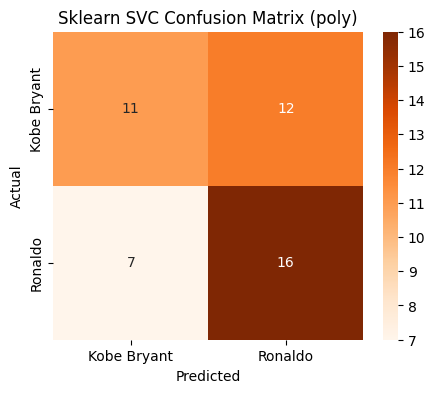

=== Kernel: sigmoid {'gamma': 0.0001, 'coef0': 0.0}
MySVM Classification Report:
              precision    recall  f1-score   support

 Kobe Bryant      0.696     0.696     0.696        23
     Ronaldo      0.696     0.696     0.696        23

    accuracy                          0.696        46
   macro avg      0.696     0.696     0.696        46
weighted avg      0.696     0.696     0.696        46



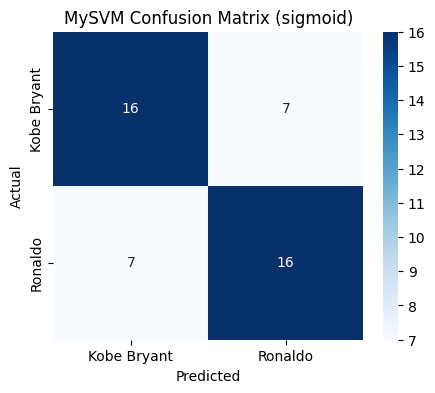

Sklearn SVC Classification Report:
              precision    recall  f1-score   support

 Kobe Bryant      0.667     0.783     0.720        23
     Ronaldo      0.737     0.609     0.667        23

    accuracy                          0.696        46
   macro avg      0.702     0.696     0.693        46
weighted avg      0.702     0.696     0.693        46



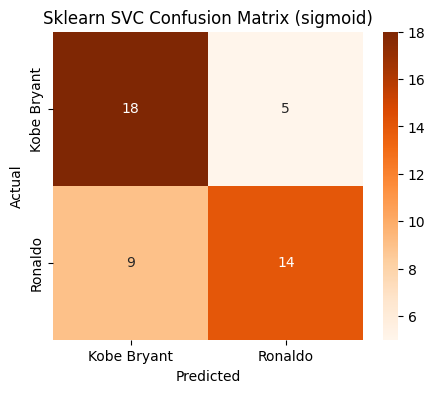

In [7]:
if __name__ == "__main__":
    main()

In [ ]:
def main_safe():
    # --- Load CSV ---
    df = pd.read_csv("star_classification.csv")

    # --- Feature engineering ---
    df['u-g'] = df['u'] - df['g']
    df['g-r'] = df['g'] - df['r']
    df['r-i'] = df['r'] - df['i']
    df['i-z'] = df['i'] - df['z']

    X = df[['u-g', 'g-r', 'r-i', 'i-z', "alpha", "delta", "MJD", 'redshift']].values
    y = df['class'].values

    # --- Encode labels ---
    le = LabelEncoder()
    y_enc = le.fit_transform(y)
    class_names = le.classes_

    # --- Split dataset ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_enc, test_size=0.3, stratify=y_enc, random_state=42
    )

    # --- Scale features ---
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # --- Kernels ---
    kernel_list = [
        ('linear', {}),
        ('rbf', {'gamma': 0.1}),
    ]

    results = []

    # --- Maximum number of samples для MySVM ---
    max_samples = 3000

    for kern, params in kernel_list:
        print("\n=== Kernel:", kern, params)

        # --- Вибірка для MySVM ---
        if X_train.shape[0] > max_samples:
            idx = np.random.choice(len(X_train), size=max_samples, replace=False)
            X_train_small = X_train[idx]
            y_train_small = y_train[idx]
        else:
            X_train_small = X_train
            y_train_small = y_train

        # === MySVM One-vs-Rest ===
        classifiers = {}
        for cls in np.unique(y_train_small):
            svm = MySVM(C=1.0, kernel=kern, **params)
            svm.fit(X_train_small, y_train_small, ovr_class=cls)
            classifiers[cls] = svm

        # Predict
        y_pred = []
        for x in X_test:
            scores = []
            for cls, clf in classifiers.items():
                scores.append(clf.project(x.reshape(1, -1))[0])
            # Вибираємо клас з максимальним score
            y_pred.append(list(classifiers.keys())[np.argmax(scores)])
        y_pred = np.array(y_pred)

        print("MySVM Classification Report:")
        print(classification_report(y_test, y_pred, target_names=class_names, digits=3))

        cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.title(f"MySVM Confusion Matrix ({kern})")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # === sklearn SVC (всі дані) ===
        sk = SVC(C=1.0, kernel=kern, **params, decision_function_shape='ovr')
        sk.fit(X_train, y_train)
        y_pred_sk = sk.predict(X_test)

        print("Sklearn SVC Classification Report:")
        print(classification_report(y_test, y_pred_sk, target_names=class_names, digits=3))

        cm_sk = confusion_matrix(y_test, y_pred_sk, labels=np.unique(y_train))
        plt.figure(figsize=(6,5))
        sns.heatmap(cm_sk, annot=True, fmt="d", cmap="Oranges", xticklabels=class_names, yticklabels=class_names)
        plt.title(f"Sklearn SVC Confusion Matrix ({kern})")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        results.append({
            'kernel': kern,
            'my_acc': accuracy_score(y_test, y_pred),
            'sk_acc': accuracy_score(y_test, y_pred_sk),
            'my_train_samples': X_train_small.shape[0]
        })

    # --- Summary ---
    print("Summary:")
    for r in results:
        print(r)

In [23]:
main_safe()


=== Kernel: linear {}


KeyboardInterrupt: 